In [1]:
%matplotlib inline
from directSolve import DS
import numpy as np, matplotlib.pyplot as plt
import pystokes
import matelms as me

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

___________________

Try different simulator in case it's actually the ODE solver that goes wrong:

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.      
S0  = -3/50*D0    # beta = 1 (positive beta is a puller (negative V2s))

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, -0.,0. , 0., 0.])

#initial angle
th = np.zeros(3*Np)

#initial orientation: 50 deg towards each other
p0_  = np.array([0., 1., 0.])
p01_ = rotation(p0_, 0., 0., -25*2*np.pi/360)
p02_ = rotation(p0_, 0., 0., 25*2*np.pi/360)
p0   = np.zeros(3*Np)
p0[::Np]  = p01_
p0[1::Np] = p02_

#p0=np.array([1., -1., 0.,0., 0.,0.])

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p0[i]*p0[i] -1)
    S[i + Np]  = S0*(3*p0[i]*p0[i+Np])
    S[i + 2*Np]= S0*(3*p0[i]*p0[i+2*Np])
    S[i + 3*Np]= S0*(3*p0[i+Np]*p0[i+Np]-1)
    S[i + 4*Np]= S0*(3*p0[i+Np]*p0[i+2*Np])
    
    D[i]       = D0*p0[i]
    D[i+Np]    = D0*p0[i+Np]
    D[i+2*Np]  = D0*p0[i+2*Np]

In [5]:
def rhs(rth):
    """
    Function that gives rhs for equations dr/dt=v and d theta/dt=o
    """
    
    #position and angle theta (relative to initial angle)
    r = rth[0:3*Np]; th = rth[3*Np:6*Np]
    
    #placeholder for current rotation
    p = np.zeros(3*Np)
    
    
    #compute current orientation via initial orientation p0 and current angle th
    for i in range(Np):
        p[i], p[i+Np], p[i+2*Np] = rotation(np.array([p0[i],p0[i+Np],p0[i+2*Np]]), th[i], th[i+Np], th[i+2*Np])
                                            
        S[i]       = S0*(3*p[i]*p[i] -1)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    #no inertia, set velocities and angular velocities to zero
    #forces and torques could be set non-zero
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=1.9, ljr=2.1)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ds.directSolve_new(v, o, r, F, T, S, D, rcond=1e-2)
    
    #return velocity and angular velocity as right-hand side
    return np.concatenate( (v,o) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
#initiallize system and forces
ds = DS(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system

rth0 = np.concatenate((r,th))
Tf = 20.
Npts = 100

X = simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000., 
             method='Radau')
X.message

'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

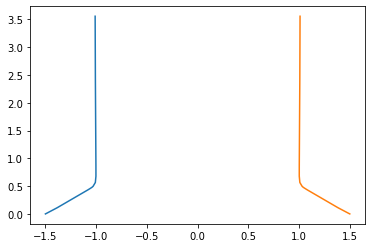

In [10]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,1], pos2[:,0], pos2[:,1])

In [11]:
#times

In [12]:
np.amin(np.abs(pos1[:,0]-pos2[:,0]))

2.0040735703833774

In [25]:
## spheres do not seem to rotate much. 

 
Comments:

    -result has nothing to do with force - actually is the same without LJ potential
    -step size becomes too small - either a stiff problem or solution wrong
    -Try with different parameters:
        *(3t) only, and straight upwards polarisation: seems to work, they repell eachother
        *add (2s) with straight upwards polarisation: 
                - when S is negative, it does not work at all
                - when S is positive, it does work and they swim apart (stronger repulsion than (3t) alone even when S is 1e2 times smaller than D). When they are of the same order, we get: takes forever.
                - only S: positive, they separate. negative, they attracht each other --> seems to do something funny long before they overlap.
                --> Check what happens to matrix elements etc when xij smaller than 2

In [26]:
minIndex = np.where((pos1[:,0]- pos2[:,0])==np.amax(pos1[:,0]- pos2[:,0]))
#minIndex[0][0] -= 28
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]

In [27]:
minIndex

(array([12]),)

In [28]:
xik,yik,zik

(-2.0040735703833774, -1.8168918591854322e-09, 4.85144628252831e-10)

In [29]:
np.trace(np.linalg.inv(me.hatGHH(xik,yik,zik, b,eta)))

788.3627924682985

In [30]:
bla = np.arange(-2.5,6.5,0.01)
invGHH = np.zeros(bla.shape[0])
j=0
for i in bla:
    invGHH[j]=np.linalg.norm(np.linalg.pinv(me.hatGHH(xik+i,yik,zik, b,eta), rcond=1e-15))
    j+=1

Text(0, 0.5, 'norm invhatGHH')

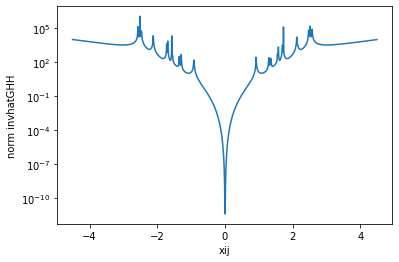

In [31]:
plt.semilogy(xik+bla, invGHH)
plt.xlabel('xij')
plt.ylabel('norm invhatGHH')

In [32]:
## higher cutoff for small singular values rcond helps, but GHH^-1
## still explodes for xij > 4

In [33]:
u, s, vh = np.linalg.svd(me.hatGHH(xik-0.3,yik,zik, b,eta))

In [34]:
s

array([0.32414802, 0.25424197, 0.21195492, 0.18636842, 0.1384273 ,
       0.12448535, 0.08249003, 0.07105116, 0.06794135, 0.04606313,
       0.04230384, 0.02243744, 0.02187955, 0.00135017, 0.00134135,
       0.00114689, 0.0009053 ])

In [35]:
xik

-2.0040735703833774

In [36]:
## clearly invGHH has some singular points - see others

In [37]:
bla = np.arange(-2.5,6.5,0.01)
G   = np.zeros(bla.shape[0])
j=0
for i in bla:
    G[j]=np.linalg.norm(me.hatGHH(xik+i,yik,zik, b,eta))
    j+=1

Text(0, 0.5, 'norm hatGHH')

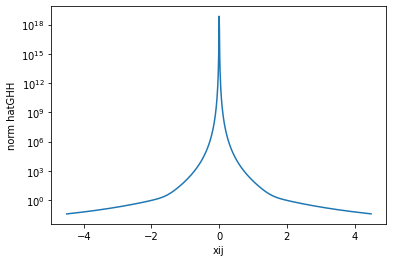

In [38]:
plt.semilogy(xik+bla, G)
plt.xlabel('xij')
plt.ylabel('norm hatGHH')

In [39]:
me.G1s2a(xik,yik,zik, b=0.3,eta=0.1).T

array([[ 0.00000000e+00, -7.19468261e-12, -2.69444605e-11],
       [ 7.19468261e-12,  0.00000000e+00,  2.97203606e-02],
       [ 2.69444605e-11, -2.97203606e-02,  0.00000000e+00]])

In [40]:
me.G2a1s(-xik,-yik,-zik, b=0.3,eta=0.1)/2

array([[ 0.00000000e+00, -7.19468261e-12, -2.69444605e-11],
       [ 7.19468261e-12,  0.00000000e+00,  2.97203606e-02],
       [ 2.69444605e-11, -2.97203606e-02,  0.00000000e+00]])

In [41]:
me.G2s3a(xik,yik,zik, b,eta).T 

array([[ 0.00000000e+00,  4.77697591e-11,  1.78900232e-10,
         1.08270085e-19,  1.88283465e-19],
       [-3.18465061e-11,  1.80450142e-20, -8.22212818e-02,
        -1.59232530e-11, -1.19266821e-10],
       [-1.19266821e-10,  8.22212818e-02, -1.80450142e-20,
         1.78900232e-10, -3.18465061e-11],
       [-1.08270085e-19,  1.19424398e-11, -2.23625290e-10,
         0.00000000e+00,  4.93327691e-02],
       [-3.28885127e-02,  7.45417632e-11,  5.17505724e-11,
        -3.28885127e-02,  1.80450142e-20]])

In [42]:
me.G3a2s(-xik,-yik,-zik, b,eta) 

array([[ 0.00000000e+00,  7.16546387e-11,  2.68350348e-10,
         1.62405128e-19,  2.82425197e-19],
       [-7.16546387e-11,  0.00000000e+00, -1.47998307e-01,
        -1.79136597e-11, -2.01262761e-10],
       [-2.68350348e-10,  1.47998307e-01,  0.00000000e+00,
         3.35437935e-10, -5.37409790e-11],
       [-1.62405128e-19,  1.79136597e-11, -3.35437935e-10,
         0.00000000e+00,  7.39991536e-02],
       [-2.82425197e-19,  2.01262761e-10,  5.37409790e-11,
        -7.39991536e-02,  0.00000000e+00]])

### How does FH behave for the new solver?

In [43]:
minIndex = np.where((pos1[:,0]- pos2[:,0])==np.amax(pos1[:,0]- pos2[:,0]))
#minIndex[0][0] -= 28
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
xik,yik,zik

(-2.0040735703833774, -1.8168918591854322e-09, 4.85144628252831e-10)

In [44]:
theta = X.y.T[:,3*Np:6*Np]

##angles at minimum distance above
theta = theta[minIndex,:][0][0]

In [45]:
F, T = np.zeros(3*Np), np.zeros(3*Np)
pol = np.zeros(3*Np)

v_ = np.zeros([3])
o_ = np.zeros([3])

for i in range(Np): #rotated relative from initial polarisation (defined as theta=0)
        pol[i], pol[i+Np], pol[i+2*Np] = rotation(np.array([p0[i],p0[i+Np],p0[i+2*Np]]), theta[i], theta[i+Np], theta[i+2*Np])
                                            
        S[i]       = S0*(3*pol[i]*pol[i] -1)
        S[i + Np]  = S0*(3*pol[i]*pol[i+Np])
        S[i + 2*Np]= S0*(3*pol[i]*pol[i+2*Np])
        S[i + 3*Np]= S0*(3*pol[i+Np]*pol[i+Np]-1)
        S[i + 4*Np]= S0*(3*pol[i+Np]*pol[i+2*Np])
    
        D[i]       = D0*pol[i]
        D[i+Np]    = D0*pol[i+Np]
        D[i+2*Np]  = D0*pol[i+2*Np]
        
i=0
j=1
        
k=j ## sum over all other particles apart from i
hatFH_j = np.zeros(17)
rhs = np.zeros(17)

force_k  = np.array([F[k],F[k+Np], F[k+2*Np]])
torque_k = np.array([T[k],T[k+Np], T[k+2*Np]])
S_k = np.array([S[k],S[k+Np],S[k+2*Np],S[k+3*Np],S[k+4*Np]])
D_k = np.array([D[k],D[k+Np],D[k+2*Np]])
VH_k = np.concatenate([S_k,D_k, np.zeros(12)])
                            
hatVH_k = np.concatenate([S_k,np.zeros(12)])
                            
rhs += (np.dot(me.hatGH1s(xik,yik,zik, b,eta), force_k)
         + 1./b * np.dot(me.hatGH2a(xik,yik,zik, b,eta), torque_k)
         + np.dot(me.hatKHH(xik,yik,zik, b,eta),hatVH_k)
         + ds.g3t * np.dot(me.hatGH3t(xik,yik,zik, b,eta), D_k))

k=i ## when k=i
S_i = np.array([S[i],S[i+Np],S[i+2*Np],S[i+3*Np],S[i+4*Np]])
hatVH_i = np.concatenate([ds.halfMinusKoHH * S_i, np.zeros(12)])
                            
rhs += - hatVH_i

k=j ## in sum over j
#lhs = me.hatGHH(xik,yik,zik, b,eta)
#hatFH_j = np.linalg.solve(lhs, rhs)
lhs_inv = np.linalg.pinv(me.hatGHH(xik,yik,zik, b,eta), rcond=1e-2)
hatFH_j = np.dot(lhs_inv, rhs)

F3t_j = -ds.g3t*D_k
FH_j = np.concatenate([hatFH_j[0:5], F3t_j, hatFH_j[5:]])
                    
v_ += (np.dot(me.G1s1s(xik,yik,zik, b,eta), force_k)
       + 1./b * np.dot(me.G1s2a(xik,yik,zik, b,eta), torque_k)
       - np.dot(me.G1sH(xik,yik,zik, b,eta), FH_j)
        + np.dot(me.K1sH(xik,yik,zik, b,eta), VH_k))
                    
o_ += 0.5/b*(np.dot(me.G2a1s(xik,yik,zik, b,eta), force_k)
      + 1./b * np.dot(me.G2a2a(xik,yik,zik, b,eta), torque_k)
      - np.dot(me.G2aH(xik,yik,zik, b,eta), FH_j)
      + np.dot(me.K2aH(xik,yik,zik, b,eta), VH_k))


In [46]:
rhs

array([-3.61793170e-02,  2.59142196e-02,  1.77068227e-11,  6.54652400e-02,
        4.70402394e-11, -3.23106866e-12,  3.83713453e-12, -6.67357620e-03,
        3.47068296e-12, -6.33144584e-03, -2.04419091e-02, -1.23737976e-02,
        5.45695828e-12,  7.06117263e-03,  3.50955094e-12,  1.03926109e-02,
       -5.40151097e-13])

In [47]:
hatVH_k

array([ 4.21309891e-02,  5.38249051e-02,  2.29117550e-11, -1.02130989e-01,
       -6.90146223e-11,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [48]:
pol[::Np]

array([3.15075043e-01, 9.49066761e-01, 4.50621270e-10])

In [49]:
v_

array([ 7.93549863e-02, -2.34361001e-02, -3.97300126e-11])

In [50]:
np.sum(hatFH_j)

16.66732641256087

In [23]:
bla = np.arange(-2.5,9.6,0.1)
FHsum = np.zeros(bla.shape[0])
hatFH_j = np.zeros(19)
rhs = np.zeros(19)
m=0
for n in bla:
    rhs += (np.dot(me.hatGH1s(xik+n,yik,zik, b,eta), force_k)
         + 1./b * np.dot(me.hatGH2a(xik+n,yik,zik, b,eta), torque_k)
         + np.dot(me.hatKHH(xik+n,yik,zik, b,eta),hatVH_k)
         + ds.g3t * np.dot(me.hatGH3t(xik+n,yik,zik, b,eta), D_k))

    k=i ## when k=i
    S_i = np.array([S[i],S[i+Np],S[i+2*Np],S[i+3*Np],S[i+4*Np]])
    hatVH_i = np.concatenate([ds.halfMinusKoHH * S_i, np.zeros(14)])
                            
    rhs += - hatVH_i

    k=j ## in sum over j
    lhs_inv = np.linalg.pinv(me.hatGHH(xik,yik,zik, b,eta), rcond=1e-2)
    hatFH_j = np.dot(lhs_inv, rhs)
    F3t_j = -ds.g3t*D_k
    FH_j = np.concatenate([hatFH_j[0:5], F3t_j, hatFH_j[5:]])
    
    FHsum[m]=np.sum(np.dot(me.G1sH(xik,yik,zik, b,eta), FH_j))
    m+=1

Text(0, 0.5, 'sumFH')

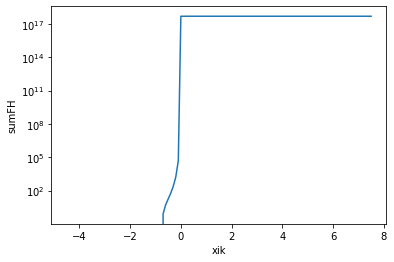

In [24]:
plt.semilogy(xik+bla, FHsum)
plt.xlabel('xik')
plt.ylabel('sumFH')

In [81]:
bla  = np.arange(-2.5,5.,0.001)
cond = np.zeros(bla.shape[0])
j=0
for i in bla:
    cond[j]=np.linalg.cond(me.GHH(xik+i,yik,zik, b,eta))
    j+=1

Text(0, 0.5, 'cond GHH')

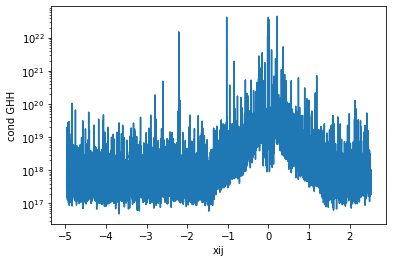

In [104]:
plt.semilogy(xik+bla, cond)
plt.xlabel('xij')
plt.ylabel('cond GHH')

In [141]:
invGHH = np.linalg.pinv(me.hatGHH(xik,yik,zik, b,eta),rcond=1e-5)

In [142]:
np.amax(invGHH)

360.6135718545148

In [143]:
invGHH.shape

(19, 19)

### How does FH behave for the old solver?

In [16]:
theta = X.y.T[:,3*Np:6*Np]

##angles at minimum distance above
theta = theta[minIndex,:][0][0]

In [17]:
k=0

F, T = np.zeros(3*Np), np.zeros(3*Np)
pol = np.zeros(3*Np)

for i in range(Np): #rotated relative from initial polarisation (defined as theta=0)
        pol[i], pol[i+Np], pol[i+2*Np] = rotation(np.array([p0[i],p0[i+Np],p0[i+2*Np]]), theta[i], theta[i+Np], theta[i+2*Np])
                                            
        S[i]       = S0*(3*pol[i]*pol[i] -1)
        S[i + Np]  = S0*(3*pol[i]*pol[i+Np])
        S[i + 2*Np]= S0*(3*pol[i]*pol[i+2*Np])
        S[i + 3*Np]= S0*(3*pol[i+Np]*pol[i+Np]-1)
        S[i + 4*Np]= S0*(3*pol[i+Np]*pol[i+2*Np])
    
        D[i]       = D0*pol[i]
        D[i+Np]    = D0*pol[i+Np]
        D[i+2*Np]  = D0*pol[i+2*Np]


rhs = np.zeros(22)
FH = np.zeros(22)

force_k  = np.array([F[k],F[k+Np], F[k+2*Np]])
torque_k = np.array([T[k],T[k+Np], T[k+2*Np]])
S_k = np.array([S[k],S[k+Np],S[k+2*Np],S[k+3*Np],S[k+4*Np]])
D_k = np.array([D[k],D[k+Np],D[k+2*Np]])
VH_k = np.concatenate([S_k,D_k,np.zeros(14)])

rhs += (np.dot(me.GH1s(xjk,yjk,zjk, b,eta), force_k) 
                                   + 1./b * np.dot(me.GH2a(xjk,yjk,zjk, b,eta), torque_k)
                                   - np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k))

#F2s = -ds.g2s*S_k
#F3t = -ds.g3t*D_k
#FH += np.concatenate([F2s,F3t,np.zeros(14)])

In [18]:
##current orientation of particle 1
pol[::Np]

array([4.08934712e-01, 9.12563642e-01, 2.19215165e-13])

In [19]:
lhs_inv = np.linalg.pinv(me.GHH(xjk,yjk,zjk, b,eta))
FH += np.dot(lhs_inv, rhs)
FH

array([-5.90396519e+08,  2.13119104e+00, -2.84515348e+01, -1.18079304e+09,
        3.22502918e+00, -1.35656731e+08, -1.10555534e+01, -1.24176502e+03,
       -4.70685724e-01,  2.87812235e+02,  1.97383857e+00, -9.41371449e-01,
       -3.44668155e+08, -5.02430197e+07,  1.38976773e+01,  5.28705915e+01,
       -4.18751197e+08,  2.01296855e+00,  3.18265158e+08,  1.38976958e+01,
       -6.25194509e+02,  1.38976835e+01])

In [20]:
-np.dot(me.G1sH(xjk,yjk,zjk, b,eta), FH)

array([ 8.09176095e+06, -3.30441522e-02,  1.18733741e+00])

In [21]:
np.dot(me.K1sH(xjk,yjk,zjk, b,eta),VH_k)

array([-2.22914479e-04,  6.01793384e-03,  1.54956887e-15])

G1sH x FH gives huge values of velocity and angular velocity for both modes on 
What happens for one mode only?
(3t) minimum distance gives very normal values
(2s) negative: huge values 
(2s) positive: huge values

In [22]:
ds.G01s*force_k + 0.2*D_k

array([0., 0., 0.])

In [23]:
rhs

array([-3.16126162e-02,  5.42104408e-02,  1.27739747e-14,  7.76120281e-02,
        2.97200339e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

As soon as (2s) is on and negative, G1sH x FH is huge. FH itself is huge. rhs is small, but lhs_inv is huge. 

Have to re-formulate problem, make G^HH invertible. 

1/2 - K^HH is probably not quite right, and G^HH invert. re-do solving for F^H

In [24]:
- np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k)

array([-3.16126162e-02,  5.42104408e-02,  1.27739747e-14,  7.76120281e-02,
        2.97200339e-14, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

In [25]:
np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k)

array([-6.69675597e-03, -1.76640172e-03, -6.72728914e-16,  2.69616787e-03,
       -2.87134588e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [26]:
np.dot(lhs_inv, - np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k))

array([-5.90396519e+08,  2.13119104e+00, -2.84515348e+01, -1.18079304e+09,
        3.22502918e+00, -1.35656731e+08, -1.10555534e+01, -1.24176502e+03,
       -4.70685724e-01,  2.87812235e+02,  1.97383857e+00, -9.41371449e-01,
       -3.44668155e+08, -5.02430197e+07,  1.38976773e+01,  5.28705915e+01,
       -4.18751197e+08,  2.01296855e+00,  3.18265158e+08,  1.38976958e+01,
       -6.25194509e+02,  1.38976835e+01])

In [27]:
np.dot(lhs_inv,np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k))

array([ 6.23020960e+06, -6.94434954e-02,  3.00237242e-01,  1.24604190e+07,
       -3.40333723e-02,  1.43152919e+06,  4.82013395e-02,  1.31038310e+01,
        4.96709382e-03, -3.03716310e+00, -6.43159919e-02,  9.93418763e-03,
        3.63714003e+06,  5.30193740e+05, -1.72013211e-01, -5.57921416e-01,
        4.41890763e+06, -2.12426320e-02, -3.35852015e+06, -1.72013406e-01,
        6.59741826e+00, -1.72013276e-01])

In [120]:
-np.dot(me.G1sH(xjk,yjk,zjk, b,eta),np.dot(lhs_inv,np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k)))

array([-9.34999465e+04,  1.07670029e-03,  1.99792929e-01])

In [122]:
def hatGHH(xij,yij,zij, b,eta):
    return np.block([[me.G2s2s(xij,yij,zij, b,eta), me.G2s3a(xij,yij,zij, b,eta), me.G2s3s(xij,yij,zij, b,eta)],
                     [me.G3a2s(xij,yij,zij, b,eta), me.G3a3a(xij,yij,zij, b,eta), me.G3a3s(xij,yij,zij, b,eta)],
                     [me.G3s2s(xij,yij,zij, b,eta), me.G3s3a(xij,yij,zij, b,eta), me.G3s3s(xij,yij,zij, b,eta)]])

In [134]:
np.allclose(np.dot(np.linalg.inv(hatGHH(-xjk,-yjk,-zjk, b,eta)),hatGHH(xjk,yjk,zjk, b,eta)), np.identity(19))

False

___________________
Below: used BDF directly (werid handling), works with (3t) mode only, but fails with (2s) mode

In [7]:
#initiallize system and forces
ds = DS(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system

rth0 = np.concatenate((r,th))
Tf = 100.
Npts = 100

X = simulate(rth0, Tf, Npts, rhs, 'BDF')

In [8]:
sol = np.empty(0)
i=0
while X.status=='running':
    X.step()
    sol = np.append(sol, X.y)
    i += 1

In [9]:
## number of steps taken
i

45

In [10]:
positions = np.zeros(int(sol.shape[0]/2))
angles = np.zeros(int(sol.shape[0]/2))

for k in range(i):
    positions[3*k*Np:3*(k+1)*Np] = sol[6*k*Np:(6*k+3)*Np]
    angles[3*k*Np:3*(k+1)*Np]    = sol[(6*k+3)*Np:6*(k+1)*Np]

In [11]:
positions1 = positions[::Np]
positions2 = positions[1::Np]

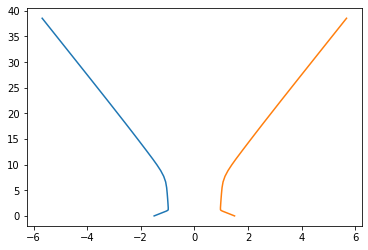

In [12]:
## x-y plot
plt.plot(positions1[::3],positions1[1::3],positions2[::3],positions2[1::3])

In [13]:
np.amin(np.abs(positions1[::3]-positions2[::3]))

1.9477701010126112